## Notes

Have a number of epochs (num-epochs) and at the start of each epoch you reset the training state

Each epoch has a number (epoch-size) of batches and at the end of each batch you update the weights

The batch is what you pass into sess.run

The batch is X, Y where X has dim [batch-size, num-steps, num-features] and Y has dim [batch-size, num-steps]

In [1]:
import rnn_functions
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import shutil
import os
from tensorflow.contrib import predictor


2019-02-06 22:41:01,669 matplotlib.backends DEBUG    backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
parameters = {
    "num_steps": 80,
    "batch_size": 150,
    "state_size": 15,
    "learning_rate": 0.1,
    "num_epochs": 10,
    "num_features": 3,
    "epoch_size": 200,
    "num_layers": 1,
    "num_level_updates": 40,
}

2019-02-06 22:41:03,501 root         DEBUG    loading entire df for river dart from sql
2019-02-06 22:41:04,315 root         DEBUG    Fill in missing timestamps by reindexing
2019-02-06 22:41:04,690 root         DEBUG    Convert cumulative rain to actual rain
2019-02-06 22:41:04,832 root         INFO     latest rain update at: 2019-02-01 22:30:00
2019-02-06 22:41:04,833 root         DEBUG    Concat rain and forecast to create model_rain
2019-02-06 22:41:04,844 root         DEBUG    interpolate model_rain
2019-02-06 22:41:05,025 matplotlib.font_manager DEBUG    findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/Users/jconn/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


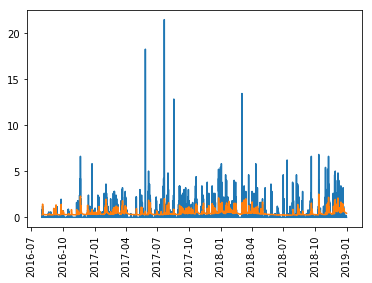

In [3]:
train_df, test_df = rnn_functions.load_data()


## Train model

EPOCH 0
('Average loss at step', 50, 'for last 50 steps:', 0.03211344350129366)
('Average loss at step', 100, 'for last 50 steps:', 0.015844663605093956)
('Average loss at step', 150, 'for last 50 steps:', 0.010659131100401282)
EPOCH 1
('Average loss at step', 50, 'for last 50 steps:', 0.009318205080926418)
('Average loss at step', 100, 'for last 50 steps:', 0.009109367271885277)
('Average loss at step', 150, 'for last 50 steps:', 0.00758505885489285)
EPOCH 2
('Average loss at step', 50, 'for last 50 steps:', 0.0074529627710580824)
('Average loss at step', 100, 'for last 50 steps:', 0.0067437248956412075)
('Average loss at step', 150, 'for last 50 steps:', 0.006446424219757318)
EPOCH 3
('Average loss at step', 50, 'for last 50 steps:', 0.006120888059958815)
('Average loss at step', 100, 'for last 50 steps:', 0.006556454598903656)
('Average loss at step', 150, 'for last 50 steps:', 0.005781462430022657)
EPOCH 4
('Average loss at step', 50, 'for last 50 steps:', 0.00589783743955195)
('Av

2019-02-06 22:44:16,999 tensorflow   INFO     Assets added to graph.


INFO:tensorflow:No assets to write.


2019-02-06 22:44:17,003 tensorflow   INFO     No assets to write.


INFO:tensorflow:SavedModel written to: /Users/jconn/isthedartrunning/analysis/models/production/saved_model.pb


2019-02-06 22:44:17,379 tensorflow   INFO     SavedModel written to: /Users/jconn/isthedartrunning/analysis/models/production/saved_model.pb


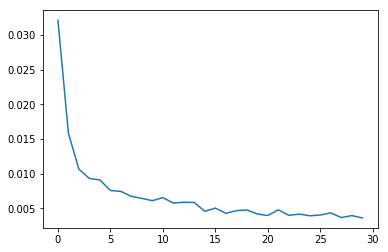

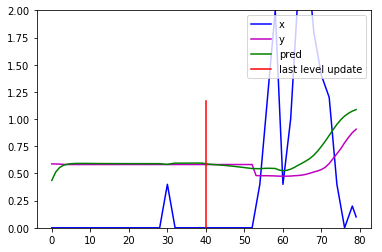

In [4]:
graph = rnn_functions.generate_graph(parameters)

training_losses, final_X, final_Y, final_pred = rnn_functions.run_training(train_df, parameters, graph, model_name="production")

plt.plot(training_losses)
plt.show()

# plot from the final predictions

rnn_functions.plot_sample(final_X, final_Y, final_pred, parameters=parameters, index=54)

In [9]:
def make_predictions(model_name, parameters, rain_threshold):
    cwd = os.getcwd()
    predict_fn = predictor.from_saved_model(os.path.join(cwd, "models", model_name))
    
    
    X_train, Y_train = rnn_functions.create_random_samples(train_df, parameters, rain_threshold=rain_threshold)
    
    train_pred = predict_fn({"x":X_train})["predictions"]
    train_bucket_pred = rnn_functions.bucket_predict({"x":X_train}, num_level_updates=parameters["num_level_updates"])
    
    train_errors = np.abs(np.array(Y_train) - np.array(train_pred))
    
    print "TRAIN DATA"
    print "\tMean absolute error:", train_errors.mean().round(4)
    print "\tRoot mean squared error:", round(math.sqrt((train_errors ** 2).mean()), 3)
    
    train_bucket_errors = np.abs(np.array(Y_train) - np.array(train_bucket_pred))
    print "\tMean absolute bucket_error:", train_bucket_errors.mean().round(4)
    print "\tRoot mean squared bucket_error:", round(math.sqrt((train_bucket_errors ** 2).mean()), 3)
    
    X_test, Y_test = rnn_functions.create_random_samples(test_df, parameters, rain_threshold=rain_threshold)
    
    test_pred = predict_fn({"x":X_test})["predictions"]
    test_bucket_pred = rnn_functions.bucket_predict({"x":X_test}, num_level_updates=parameters["num_level_updates"])

    print
    print "TEST DATA"
    test_errors = np.abs(np.array(Y_test) - np.array(test_pred))
    print "\tMean absolute error:", test_errors.mean().round(4)
    print "\tRoot mean squared error:", round(math.sqrt((test_errors ** 2).mean()), 3)
    
    test_bucket_errors = np.abs(np.array(Y_test) - np.array(test_bucket_pred))
    print "\tMean absolute bucket_error:", test_bucket_errors.mean().round(4)
    print "\tRoot mean squared bucket_error:", round(math.sqrt((test_bucket_errors ** 2).mean()), 3)

    return X_test, Y_test, test_pred, test_bucket_pred

X_test, Y_test, test_pred, test_bucket_pred = make_predictions(model_name = "production", parameters=parameters, rain_threshold=0)

INFO:tensorflow:Restoring parameters from /Users/jconn/isthedartrunning/analysis/models/production/variables/variables


2019-02-06 22:57:42,312 tensorflow   INFO     Restoring parameters from /Users/jconn/isthedartrunning/analysis/models/production/variables/variables


TRAIN DATA
	Mean absolute error: 0.0214
	Root mean squared error: 0.052
	Mean absolute bucket_error: 0.0157
	Root mean squared bucket_error: 0.073

TEST DATA
	Mean absolute error: 0.0302
	Root mean squared error: 0.064
	Mean absolute bucket_error: 0.0305
	Root mean squared bucket_error: 0.229


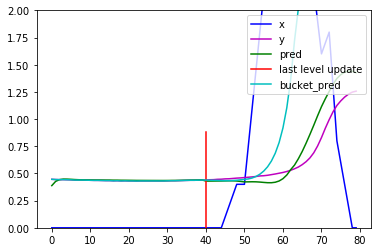

In [58]:
rnn_functions.plot_sample(X_test, Y_test, test_pred, parameters=parameters, bucket_pred=test_bucket_pred, index=random.randint(1,149))